In [1]:
import inspect
import gc
import random
import torch
import torch.nn.init as init
import torch.nn.functional as F
import Functional_Data_functions
from Functional_Data_functions import Hyperparameter_Test_n_data,LSTM_class,conv_total_out, Smoothing_method,weights_init_normal,HyperParameters,Hyperparameter_Search,Hyperparameter_Test,Hyper_parameter_GridSearch,TSCNN,Compile_train,Compare_epochs, from_torch_to_Datagrid, conv_block_out_lp,printer
from Functional_Data_functions import Compare_epochs,Compile_class,conv_total_out_no_pool,conv_total_out_without_pooling, conv_total_out_une_couche, TSConv1d,TSConv1d_hyperparam, Granulator

from scipy.stats import norm
import torch.nn as nn
from skfda.representation.basis import VectorValued as MultiBasis
from torch import optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import numpy as np
from numpy import *
import seaborn as sns
import matplotlib
#matplotlib.use('TkAgg')
from matplotlib import pyplot as plt
# import skfda as fda
# from skfda import representation as representation
# from skfda.exploratory.visualization import FPCAPlot
# # from skfda.exploratory.visualization import FPCAPlot
# # from skfda.preprocessing.dim_reduction import FPCA
# # from skfda.representation.basis import BSpline, Fourier, Monomial
import scipy
from scipy.interpolate import BSpline
import os
import ignite
from tqdm import tqdm
import sklearn
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler as scale
import random
from random import seed
from scipy import stats
import statistics
from statistics import stdev
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

import skfda
from skfda import FDataGrid as fd
from skfda.representation.basis import BSpline as B
import xgboost as xbg 
from xgboost import XGBClassifier, plot_tree,XGBRegressor
import yfinance as yf
import pandas as pd

In [2]:
def rm(tensor, indices):
    mask = torch.ones_like(tensor[:,0,0]).bool()
    mask[indices] = False
    return tensor[mask,:,:]

index des actions à retirer: 24 198 292
(445,) <class 'skfda.representation.grid.FDataGrid'>
(333, 1750, 1) (333, 1386, 1)


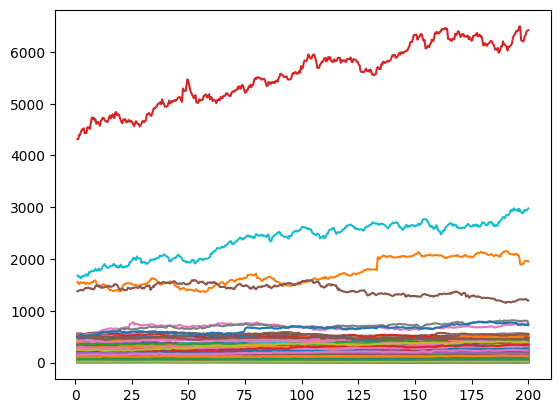

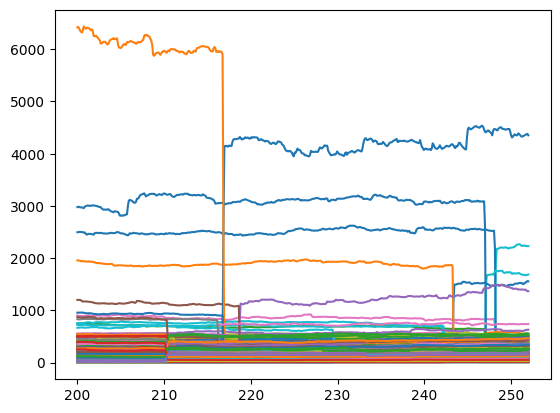

In [13]:
n_total=1750
gc.collect()
torch.cuda.empty_cache()
# csv_file_path = "cours_de_bourse.csv"
csv_file_path = "cours_de_bourse_1_an_en_heures.csv"
knots_total=25
total_basis=B(knots=linspace(1,252,knots_total),order=3)
# Utilisez pandas pour lire le fichier CSV
donnees_combinees = pd.read_csv(csv_file_path)

donnees_combinees[donnees_combinees.Symbole=="MSFT"]
donnees_combinees[donnees_combinees.Symbole=="AAPL"].values[1741] 
donnees_combinees.Symbole
names=donnees_combinees.Symbole.unique()

raw_data=donnees_combinees.values[:,2:8].astype(float)
# raw_data=donnees_combinees.values[:,0:8]
X=torch.zeros(raw_data.shape[0]//n_total,n_total,6,)
for i in range(raw_data.shape[0]//n_total):
    X[i,:,:]=torch.from_numpy(raw_data[i*n_total:(i+1)*n_total])
    # X[i,:,0]=i

X_of_interest=X[[27, 208, 302]]
X=rm(X,[27, 208, 302])
ind=range(X.shape[0])
# X[:,:,5]=(X[:,:,5]-torch.mean(X[:,:,5]))/torch.std(X[:,:,5])
# for i in range(6):
#     X[:,:,i]=torch.Tensor(scale().fit_transform(X[:,:,i].cpu()))

hours_total=n_total
hours_futur=364
hours_train=hours_total-hours_futur
grid_points_past=linspace(1,200,hours_train)
grid_points_futur=linspace(200,252,hours_futur)
grid_plot_y=linspace(200,2502,hours_futur+1)

grid_points_total=linspace(1,2502,n_total)
Y=X[:,hours_train-1:n_total-1,4].unsqueeze(2).unsqueeze(3).float().cuda()
X_grid=fd(grid_points=grid_points_past,data_matrix=X[:,:hours_train,4].numpy())
X_grid_total=fd(grid_points=grid_points_total,data_matrix=X[:,:,4].numpy())
X_grid_of_interest=fd(grid_points=grid_points_past,data_matrix=X_of_interest[:,:hours_train,4].numpy())
X_grid_total_of_interest=fd(grid_points=grid_points_total,data_matrix=X_of_interest[:,:,4].numpy())
Y_grid=fd(grid_points=grid_points_futur,data_matrix=X[:,hours_train-1:n_total-1,4].numpy())
Y_grid_total=fd(grid_points=grid_points_futur,data_matrix=X[:,hours_train-1:n_total-1,4].numpy())

print('index des actions à retirer:',argmax(names=='AMZN'),argmax(names=='INTC'),argmax(names=='NVDA'))
# x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(X_grid,Y,shuffle=True)    
print(X_grid.shape,type(X_grid))
x_train,x_test,x_total_train,x_total_test,indices_train,indices_test=sklearn.model_selection.train_test_split(X_grid,X_grid_total,ind,shuffle=True)    
# x_train,x_test,x_total_train,x_total_test,indices_train,indices_test,y_train_tensor,y_test_tensor=sklearn.model_selection.train_test_split(X_grid,X_grid_total,ind,Y,shuffle=True)    
x_train.data_matrix,X_grid_of_interest.data_matrix,x_total_train.data_matrix,x_total_test.data_matrix=x_train.data_matrix[:,:,0:1],X_grid_of_interest.data_matrix[:,:,0:1],x_total_train.data_matrix[:,:,0:1],x_total_test.data_matrix[:,:,0:1]
print(x_total_train.data_matrix.shape,x_train.data_matrix.shape)
y_train=torch.tensor(x_total_train.to_basis(basis=total_basis).coefficients).unsqueeze(2).unsqueeze(3).float().cuda()
y_test=torch.tensor(x_total_test.to_basis(basis=total_basis).coefficients).unsqueeze(2).unsqueeze(3).float().cuda()
names_train=names[indices_train]
names_test=names[indices_test]
# X=X[:,:n_total,4].permute(0,2,1).float().cuda()
# x_train_tensor,X_grid_of_interest_tensor,y_train_tensor,y_test_tensor=sklearn.model_selection.train_test_split(X,Y,shuffle=True)    


x_train.plot()
Y_grid.plot()
plt.show()
# [Y.shape,X.shape,
# #  x_train_tensor.shape,
# #  X_grid_of_interest_tensor.shape
#  y_train.shape,
#  ]

In [14]:
donnees_combinees[donnees_combinees.Symbole=="ABT"].shape
donnees_combinees[donnees_combinees.Symbole=="MSFT"].shape

donnees_combinees.shape[0]//n_total


448

In [15]:
n_knots_train=20

##Choix du nombre d'epochs 
n_epoch=2
opt='SGD'
##Création des hyperparamètres:
basis_train=B(knots=linspace(1,hours_train,n_knots_train),order=4)
param1=HyperParameters(n_epochs=n_epoch,
                        granulation=7500,
    basis=MultiBasis([
        # B(knots=linspace(1,hours_train,n_knots),order=4),
        # B(knots=linspace(1,hours_train,n_knots),order=4),
        # B(knots=linspace(1,hours_train,n_knots),order=4),
        # B(knots=linspace(1,hours_train,n_knots),order=4),
        # B(knots=linspace(1,hours_train,n_knots),order=4),
        # B(knots=linspace(1,hours_train,n_knots),order=4)
        # total_basis,
        basis_train,
        ]
        ),
        # Smoothing_mode="inter",
    n_conv_in=8, n_conv_in2=64, n_conv_in3=128,n_conv_out=2, n_Flat_out=128,
    stride_1=50, stride_2=1, stride_3=1,n_knots=8,order=3,
    stride_pool_1=2, stride_pool_2=2, stride_pool_3=2,
    kernel_size_1=55,  kernel_size_2=3, kernel_size_3=4,
    kernel_size_pool_1=5, kernel_size_pool_2=2, kernel_size_pool_3=3,
    dilation_1=75, dilation_2=1, dilation_3=1,
    dilation_pool_1=1, dilation_pool_2=1, dilation_pool_3=1,
    padding_1=2, padding_2=2, padding_3=2,
    padding_pool_1=1, padding_pool_2=1, padding_pool_3=1,
    opt=opt, lr=0.00089, loss=nn.MSELoss(),activation=nn.Identity(),negative_slope=0.17,
    derivative=[0,1,2],)
param_mlp=HyperParameters(n_conv_in=256,n_conv_in2=64, n_conv_in3=128,n_conv_out=2, n_Flat_out=256,opt=opt,
                          lr=0.00089
                          )



In [16]:
hyperparams=param1



class Market_predictor(nn.Module):
    def __init__(self,channels,):
        super(Market_predictor,self).__init__()
        self.entry_layer=nn.Sequential(
            TSConv1d_hyperparam(hyperparameter=param1)
        )
        self.conv_block=nn.Sequential(
            nn.MaxPool1d(kernel_size=hyperparams.kernel_size_pool_1,stride=hyperparams.stride_pool_1,padding=hyperparams.padding_pool_1,dilation=hyperparams.dilation_pool_1),
            nn.BatchNorm1d(hyperparams.n_conv_in),
            nn.LeakyReLU(hyperparams.negative_slope),
            nn.Dropout(p=hyperparams.DropOut),

            nn.Conv1d(param1.n_conv_in,param1.n_conv_in2,kernel_size=hyperparams.kernel_size_2,stride=hyperparams.stride_2,dilation=hyperparams.dilation_2,padding=hyperparams.padding_2),
            nn.BatchNorm1d(hyperparams.n_conv_in2),
            nn.LeakyReLU(hyperparams.negative_slope),
            nn.Dropout(p=hyperparams.DropOut),

            nn.MaxPool1d(kernel_size=hyperparams.kernel_size_pool_2,stride=hyperparams.stride_pool_2,padding=hyperparams.padding_pool_2,dilation=hyperparams.dilation_pool_2),
            nn.BatchNorm1d(hyperparams.n_conv_in2),
            nn.LeakyReLU(hyperparams.negative_slope),
            nn.Dropout(p=hyperparams.DropOut),

            nn.Conv1d(param1.n_conv_in2,param1.n_conv_in3,kernel_size=hyperparams.kernel_size_3,stride=hyperparams.stride_3,dilation=hyperparams.dilation_3,padding=hyperparams.padding_3),
            nn.BatchNorm1d(hyperparams.n_conv_in3),
            nn.LeakyReLU(hyperparams.negative_slope),
            nn.Dropout(p=hyperparams.DropOut),
            
            nn.MaxPool1d(kernel_size=hyperparams.kernel_size_pool_3,stride=hyperparams.stride_pool_3,padding=hyperparams.padding_pool_3,dilation=hyperparams.dilation_pool_3),
            nn.BatchNorm1d(hyperparams.n_conv_in3),
            nn.LeakyReLU(hyperparams.negative_slope),
            nn.Dropout(p=hyperparams.DropOut),
        )
        self.forecaster=nn.Sequential(
            nn.Flatten(),
            nn.Linear(hyperparams.n_conv_in3*conv_total_out(hyperparams),hyperparams.n_Flat_out),
            nn.BatchNorm1d(hyperparams.n_Flat_out),
            nn.LeakyReLU(hyperparams.negative_slope),
            nn.Linear(hyperparams.n_Flat_out,total_basis.n_basis),

        )

    def forward(self,x):
        TSC_out=self.entry_layer(x)
        conv_out=self.conv_block(TSC_out)
        forecast=self.forecaster(conv_out).float().unsqueeze_(2).unsqueeze_(3)
        return forecast

        


In [17]:
lstm=Compile_class(model_class="lstm",hyperparams=param1,output_size=total_basis.n_basis,x_train=x_train)
tsc=Compile_class(model_class="TSC",hyperparams=param1,output_size=total_basis.n_basis,x_train=x_train)
mlp=Compile_class(model_class='MLP',hyperparams=param_mlp,output_size=total_basis.n_basis,x_train=x_train)
market_predictor=Market_predictor(channels=1).cuda()

In [18]:

# x_train_close=x_train_tensor[:,,:].unsqueeze(1)
# X_close=X[:,4,:].unsqueeze(1)
optimizer=optim.Adam(tsc.parameters(),
                     lr=0.0001)
optimizer_market=optim.Adam(market_predictor.parameters(),
                     lr=0.0001)
optimizer_lstm=optim.Adam(lstm.parameters(),
                     lr=0.0001)
optimizer_mlp=optim.Adam(mlp.parameters(),
                     lr=0.0001)

loss=hyperparams.loss

In [21]:
eval_points=linspace(1,252,hours_total)

eval_points.shape
# y_test_tensor.shape


(1750,)

In [27]:
eval_points=linspace(1,252,hours_total)
def market_loss(y_hat,y_test,total_basis=total_basis,eval_points=eval_points):

    basis_eval_ordre_0=total_basis(eval_points=eval_points,derivative=0)
    basis_eval_ordre_1=total_basis(eval_points=eval_points,derivative=1)
    basis_fc_ordre_1=torch.from_numpy(basis_eval_ordre_0).float().cuda()
    basis_fc_ordre_0=torch.from_numpy(basis_eval_ordre_1).float().cuda()
    # basis_fc_test_ordre_1=torch.from_numpy(basis_eval_ordre_0).float().cuda()
    # basis_fc_test_ordre_0=torch.from_numpy(basis_eval_ordre_1).float().cuda()
    recons_test_ordre_0=torch.matmul(y_hat[:,:,0,0],basis_fc_ordre_0[:,:,0])
    recons_test_ordre_1=torch.matmul(y_hat[:,:,0,0],basis_fc_ordre_1[:,:,0])
    recons_ordre_0=torch.matmul(y_hat[:,:,0,0],basis_fc_ordre_0[:,:,0])
    recons_ordre_1=torch.matmul(y_hat[:,:,0,0],basis_fc_ordre_1[:,:,0])
    recons_ordre_test_0=torch.matmul(y_test[:,:,0,0],basis_fc_ordre_0[:,:,0])
    recons_ordre_test_1=torch.matmul(y_test[:,:,0,0],basis_fc_ordre_1[:,:,0])
    
    loss_entre_lissages=nn.MSELoss()(recons_ordre_0[:,hours_train-1:],
                             recons_ordre_test_0[:,hours_train-1:])
    # loss_reel=nn.MSELoss()(recons_ordre_0[:,hours_train-1:],
    #                          y_test_tensor)
    loss_entre_lissages_derive=nn.MSELoss()(recons_ordre_1[:,hours_train-1:],
                             recons_ordre_test_1[:,hours_train-1:])
    loss_coefs=nn.MSELoss()(y_hat,y_test)
    
    loss_sign_derive= nn.CrossEntropyLoss()(torch.sign(recons_ordre_1[:,hours_train-1:]),
                                            torch.sign(recons_ordre_test_1[:,hours_train-1:]))
    
    loss_weights=torch.tensor([0.2,0.2,0.2,0.2,0.2])                
    
    
    
    loss_cat=torch.cat([
        loss_sign_derive,
        loss_coefs,
        loss_entre_lissages_derive,
        loss_entre_lissages,
        # loss_reel,
        ])
    loss_totale=torch.sqrt(torch.dot(loss_cat,loss_weights))
    loss_totale=torch.sqrt(
        # 0.1*loss_reel+
        0.2*loss_entre_lissages_derive+
        0.2*loss_entre_lissages+
        0.2*loss_coefs+
        0.3*loss_sign_derive
    )
    
    
    return loss_totale


In [28]:
def train(n_epochs, module, optimizer, loss, batch_size,x_test=x_test,y_test=y_test):
    testing_acc=torch.tensor([0])

    for epoch in tqdm(range(n_epochs)):
        train_loss = torch.tensor(0).cuda().long()
        
        # Mélanger les données d'entraînement
        indices = list(range(len(x_train)))
        random.shuffle(indices)
        
        batch_index = 0  # Indice de batch
        
        for i in range(int(len(x_train) / batch_size)):
            # Obtenir les indices des données mélangées
            batch_indices = indices[batch_index:batch_index+batch_size]
            functions_train = x_train[batch_indices]
            # y_coefs_batch = X_grid_total[batch_indices]
            # labels_train = torch.tensor(y_coefs_batch.to_basis(total_basis).coefficients).unsqueeze(2).unsqueeze(3).float().cuda()
            labels_train =y_train[batch_indices]
            # touche_train=torch.Tensor(functions_train.data_matrix[:,hours_train-1,:]).float().cuda()
            optimizer.zero_grad()
            output = module(functions_train)
            loss_value = market_loss(output,labels_train)
        
            loss_value.backward()
            optimizer.step()
            train_loss += loss_value.long()
            batch_index += batch_size  # Passer au prochain batch
            
        if len(unique(y_train.cpu()))<y_train.shape[0]//2:
            # accuracy_training=((torch.sum(torch.argmax(module(x_train),dim=1)==y_train)/x_train.shape[0])*100).cpu().unsqueeze(0)
            accuracy=((torch.sum(torch.argmax(module(x_test),dim=1)==y_test)/x_test.shape[0])*100).cpu().unsqueeze(0)
            testing_acc=torch.cat([testing_acc,accuracy],dim=0)
            # training_acc=torch.cat([training_acc,accuracy_training],dim=0)
        else:
            # mse_loss_train=nn.MSELoss()(module(x_train),y_train).unsqueeze(0).cpu()
            # mse_loss_test=torch.sqrt(nn.MSELoss()(module(x_test),y_test)).unsqueeze(0).cpu()
            # testing_acc=torch.cat([testing_acc,mse_loss_test.cpu()],dim=0).cpu()
            loss_test=market_loss(module(x_test),y_test=y_test).unsqueeze(0).cpu()
            testing_acc=torch.cat([testing_acc,loss_test.cpu()],dim=0).cpu()
            # training_acc=torch.cat([training_acc,mse_loss_train.cpu()],dim=0).cpu()
        gc.collect()
        torch.cuda.empty_cache()


    return testing_acc.detach().cpu()


In [29]:
n_epochs=500
batch_size=130
train_tracker_market_p =train(module=market_predictor,optimizer=optimizer_market,
                    #  y_test= torch.tensor(.to_basis(total_basis).coefficients).unsqueeze(2).unsqueeze(3).float().cuda()
                     n_epochs=n_epochs,loss=loss,batch_size=batch_size,
                     )
train_tracker_tsc =train(module=tsc,optimizer=optimizer,
                     n_epochs=n_epochs,loss=loss,batch_size=batch_size)
                    #  y_test= torch.tensor(.to_basis(total_basis).coefficients).unsqueeze(2).unsqueeze(3).float().cuda()
# train_tracker_lstm =train(module=lstm,optimizer=optimizer_lstm,
#                      n_epochs=n_epochs,loss=loss,batch_size=batch_size,
#                      )
train_tracker_mlp=train(module=mlp,optimizer=optimizer_mlp,
                     n_epochs=n_epochs,loss=loss,batch_size=batch_size)


  0%|          | 0/500 [00:01<?, ?it/s]


RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [17]:
train_tracker_mlp=train(module=mlp,optimizer=optimizer_mlp,
                     n_epochs=1000,loss=loss,batch_size=batch_size)


100%|██████████| 1000/1000 [02:19<00:00,  7.17it/s]


C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_32496\1408564106.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_train.show()


[tensor(298), tensor(299), tensor(998)]

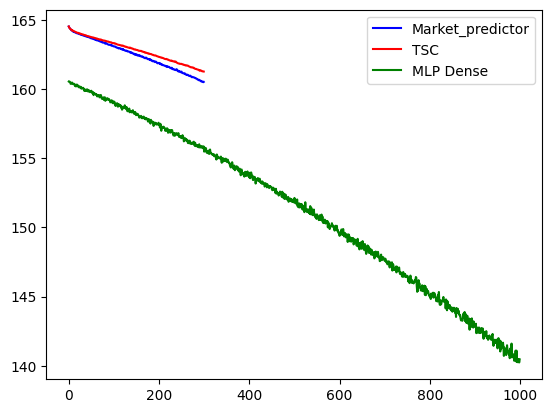

In [18]:
fig_train,ax_train=plt.subplots()
ax_train.plot(train_tracker_market_p[1:],color="blue",label="Market_predictor")
ax_train.plot(train_tracker_tsc[1:],color="red",label="TSC")
# ax_train.plot(train_tracker_lstm[1:],color="magenta",label="lstm")
ax_train.plot(train_tracker_mlp[1:],color="green",label="MLP Dense ")
ax_train.legend()
fig_train.show()
[
torch.argmin(train_tracker_market_p[1:]),
torch.argmin(train_tracker_tsc[1:]),
# torch.argmin(train_tracker_lstm[1:]),
torch.argmin(train_tracker_mlp[1:]),
]

In [27]:
eval_points=linspace(1,252,7500)


y_hat=mlp(x_test)[:,:,0,0]
y_hat_lstm=lstm(x_test)[:,:,0,0]
y_hat_tsc=tsc(x_test)[:,:,0,0]
y_hat_market=market_predictor(x_test)[:,:,0,0]
k=np.random.randint(105)

basis_eval=total_basis(eval_points=eval_points)
basis_fc=torch.from_numpy(basis_eval).float().cuda()
recons=torch.matmul(y_hat,basis_fc[:,:,0])
recons_test=torch.matmul(y_hat,basis_fc[:,:,0])
recons_test_lstm=torch.matmul(y_hat_lstm,basis_fc[:,:,0])
recons_test_tsc=torch.matmul(y_hat_tsc,basis_fc[:,:,0])
recons_test_market=torch.matmul(y_hat_market,basis_fc[:,:,0])
# x_test[k].plot()
# print("Réalité")
# skfda.FDataBasis(basis=total_basis,coefficients=y_test[k,:,0,0].detach().cpu()).plot()

fig,ax=plt.subplots(2,2,figsize=(16,16))
ax[0,0].plot(eval_points,torch.t(recons_test_market[k]).detach().cpu(),label="market_predictor de cristale")
ax[0,1].plot(eval_points,torch.t(recons_test[k]).detach().cpu(),label="mlp")
ax[1,0].plot(eval_points,torch.t(recons_test_lstm[k]).detach().cpu(),label="lstm")
ax[1,1].plot(eval_points,torch.t(recons_test_tsc[k]).detach().cpu(),label="tsc")
ax[0,0].set_title("Market predictor")
ax[0,1].set_title("MLP")
ax[1,1].set_title("TSC")
ax[1,0].set_title("lstm")
# ax[0].legend()
fig_reel,ax_reel=plt.subplots()
ax_reel.plot(grid_points_past,x_test.data_matrix[k,:,0],color="black")
ax_reel.plot(grid_points_futur,x_total_test.data_matrix[k,hours_train:n_total],color="black")
ax_reel.set_title("LA vraie vie")
# ax[0].set_ylim(0,200)
# ax[1].set_ylim(0,200)
fig.show()
fig_reel.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (112x13 and 253x7500)

In [107]:
total_basis

BSpline(domain_range=((1.0, 252.0),), n_basis=13, order=4, knots=(1.0, 26.1, 51.2, 76.30000000000001, 101.4, 126.5, 151.60000000000002, 176.70000000000002, 201.8, 226.9, 252.0))

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_13144\1655927581.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_13144\1655927581.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_reel.show()


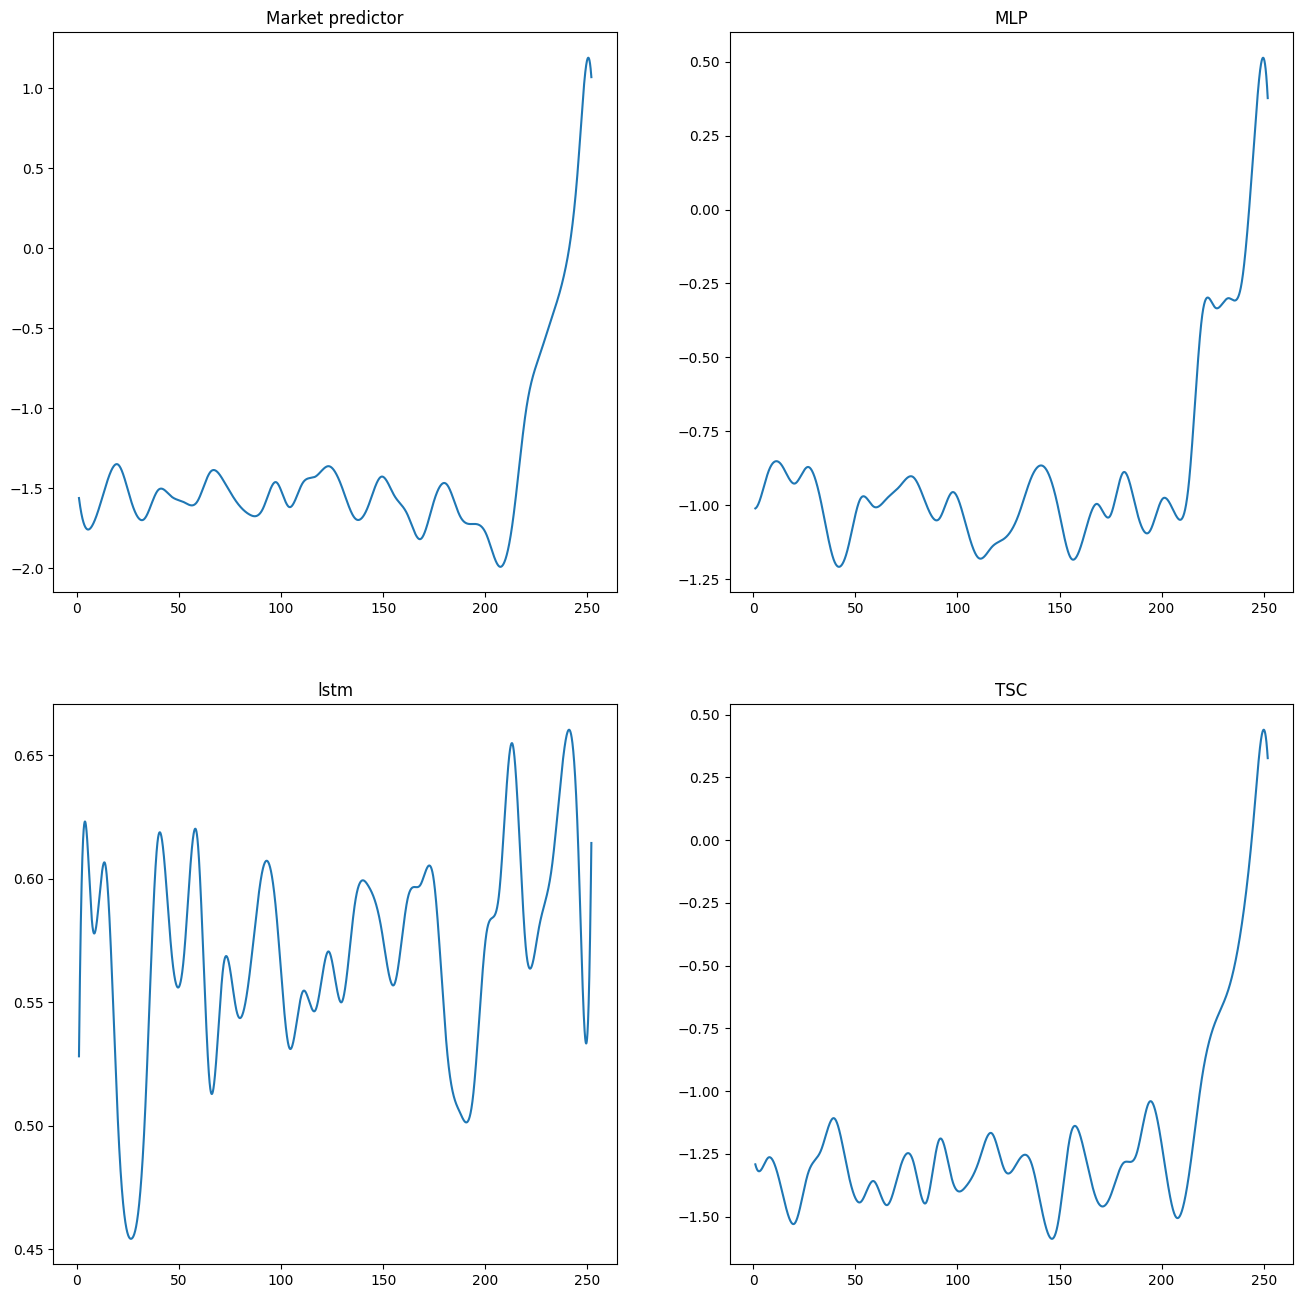

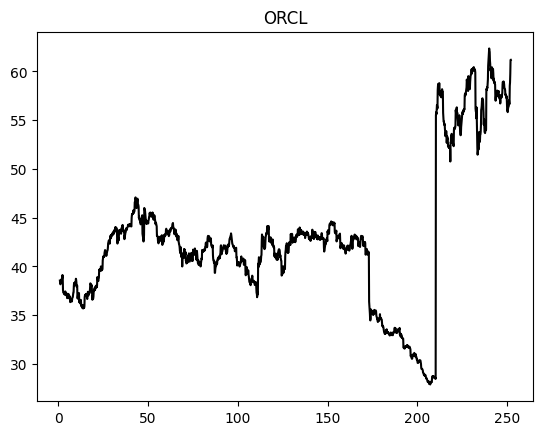

In [ ]:
eval_points=linspace(1,252,7500)


y_hat=mlp(x_test)[:,:,0,0]
y_hat_lstm=lstm(x_test)[:,:,0,0]
y_hat_tsc=tsc(x_test)[:,:,0,0]
y_hat_market=market_predictor(x_test)[:,:,0,0]
# k=np.random.randint(0)
k=1
basis_eval=total_basis(eval_points=eval_points)
basis_fc=torch.from_numpy(basis_eval).float().cuda()
recons=torch.matmul(y_hat,basis_fc[:,:,0])
recons_test=torch.matmul(y_hat,basis_fc[:,:,0])
recons_test_lstm=torch.matmul(y_hat_lstm,basis_fc[:,:,0])
recons_test_tsc=torch.matmul(y_hat_tsc,basis_fc[:,:,0])
recons_test_market=torch.matmul(y_hat_market,basis_fc[:,:,0])
# x_test[k].plot()
# print("Réalité")
# skfda.FDataBasis(basis=total_basis,coefficients=y_test[k,:,0,0].detach().cpu()).plot()
moyenne=mean(x_test.data_matrix[k,:])
x_test_norm=(x_test.data_matrix[k]-moyenne)/var(x_test.data_matrix[k])
fig,ax=plt.subplots(2,2,figsize=(16,16))
ax[0,0].plot(eval_points,torch.t(recons_test_market[k]).detach().cpu(),label="market_predictor de cristale")
ax[0,1].plot(eval_points,torch.t(recons_test[k]).detach().cpu(),label="mlp")
ax[1,0].plot(eval_points,torch.t(recons_test_lstm[k]).detach().cpu(),label="lstm")
ax[1,1].plot(eval_points,torch.t(recons_test_tsc[k]).detach().cpu(),label="tsc")
ax[0,0].set_title("Market predictor")
ax[0,1].set_title("MLP")
ax[1,1].set_title("TSC")
ax[1,0].set_title("lstm")
# ax[0].legend()
fig_reel,ax_reel=plt.subplots()
ax_reel.plot(grid_points_past,x_test.data_matrix[k,:,0],color="black")
ax_reel.plot(grid_points_futur,x_total_test.data_matrix[k,hours_train:n_total],color="black")
ax_reel.set_title(names[302])
# ax[0].set_ylim(0,200)
# ax[1].set_ylim(0,200)
fig.show()
fig_reel.show()

IndexError: index 5 is out of bounds for dimension 0 with size 3

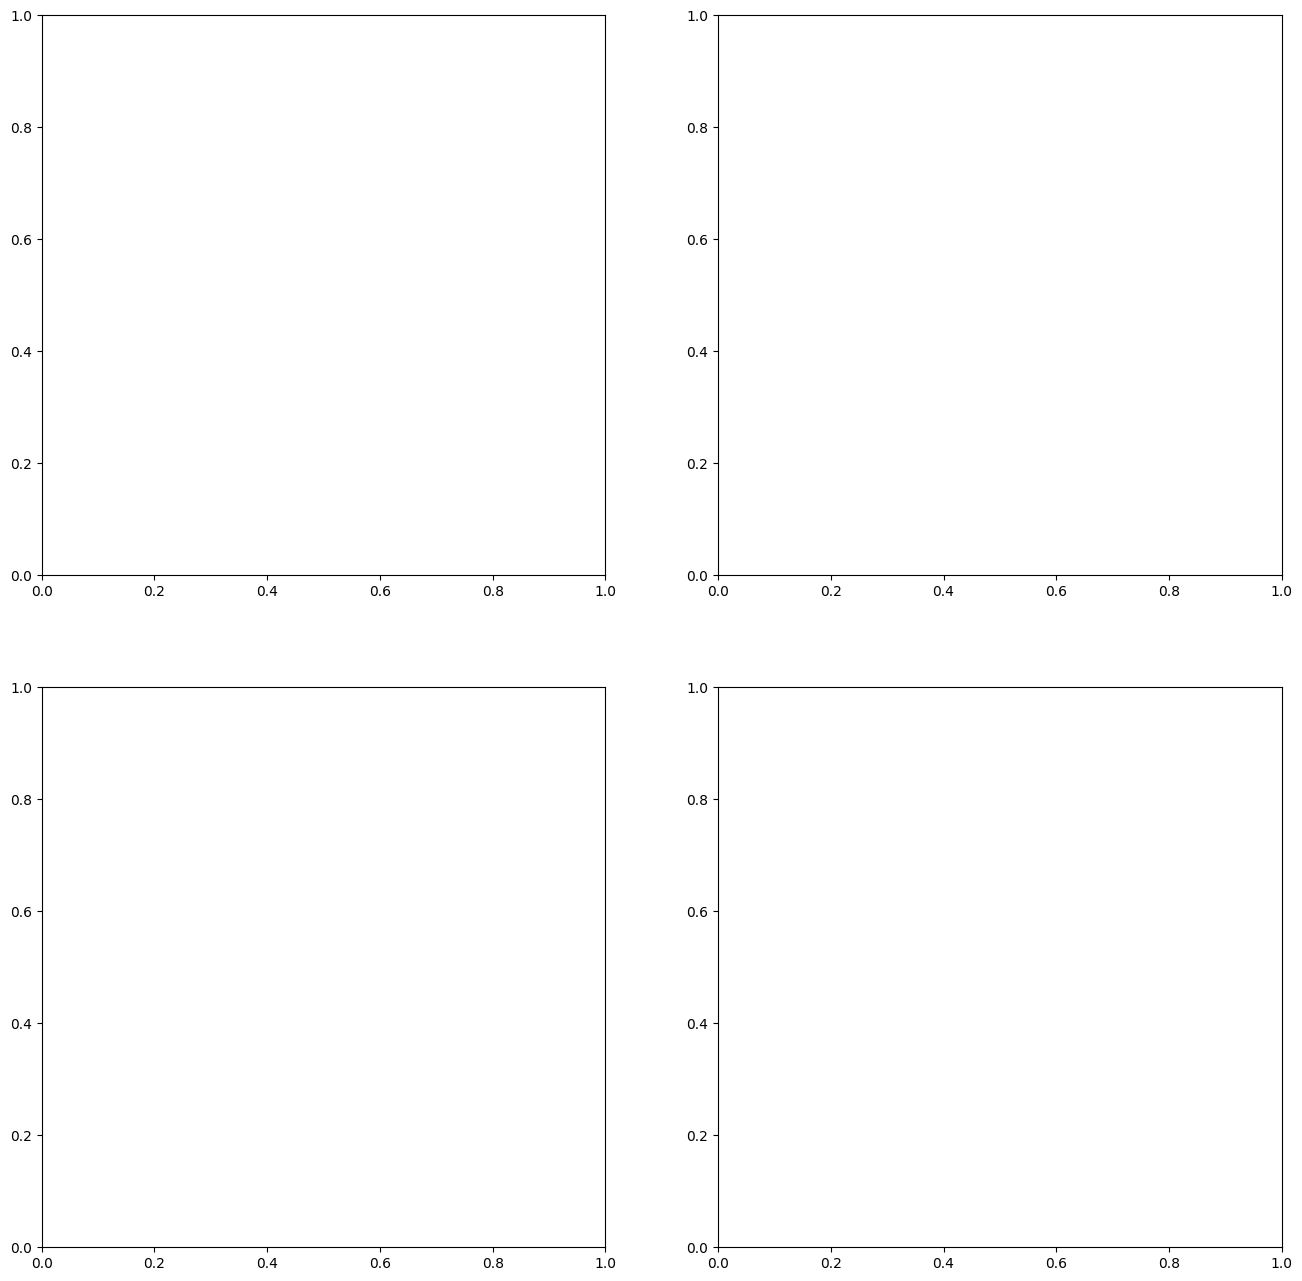

In [228]:
eval_points=linspace(1,252,7500)


y_hat=mlp(X_grid_of_interest)[:,:,0,0]
y_hat_lstm=lstm(X_grid_of_interest)[:,:,0,0]
y_hat_tsc=tsc(X_grid_of_interest)[:,:,0,0]
y_hat_market=market_predictor(X_grid_of_interest)[:,:,0,0]
# k=np.random.randint(105)

basis_eval=total_basis(eval_points=eval_points)
basis_fc=torch.from_numpy(basis_eval).float().cuda()
recons=torch.matmul(y_hat,basis_fc[:,:,0])
recons_test=torch.matmul(y_hat,basis_fc[:,:,0])
recons_test_lstm=torch.matmul(y_hat_lstm,basis_fc[:,:,0])
recons_test_tsc=torch.matmul(y_hat_tsc,basis_fc[:,:,0])
recons_test_market=torch.matmul(y_hat_market,basis_fc[:,:,0])
# x_test[k].plot()
# print("Réalité")
# skfda.FDataBasis(basis=total_basis,coefficients=y_test[k,:,0,0].detach().cpu()).plot()

fig,ax=plt.subplots(2,2,figsize=(16,16))
ax[0,0].plot(eval_points,torch.t(recons_test_market[k]).detach().cpu(),label="market_predictor de cristale")
ax[0,1].plot(eval_points,torch.t(recons_test[k]).detach().cpu(),label="mlp")
ax[1,0].plot(eval_points,torch.t(recons_test_lstm[k]).detach().cpu(),label="lstm")
ax[1,1].plot(eval_points,torch.t(recons_test_tsc[k]).detach().cpu(),label="tsc")
ax[0,0].set_title("Market predictor")
ax[0,1].set_title("MLP")
ax[1,1].set_title("TSC")
ax[1,0].set_title("lstm")
# ax[0].legend()
fig_reel,ax_reel=plt.subplots()
ax_reel.plot(grid_points_past,X_grid_of_interest.data_matrix[k,:,0],color="black")
ax_reel.plot(grid_points_futur,X_grid_total_of_interest.data_matrix[k,hours_train:n_total],color="black")
ax_reel.set_title("LA vraie vie")
# ax[0].set_ylim(0,200)
# ax[1].set_ylim(0,200)
fig.show()
fig_reel.show()

torch.Size([112, 7500])


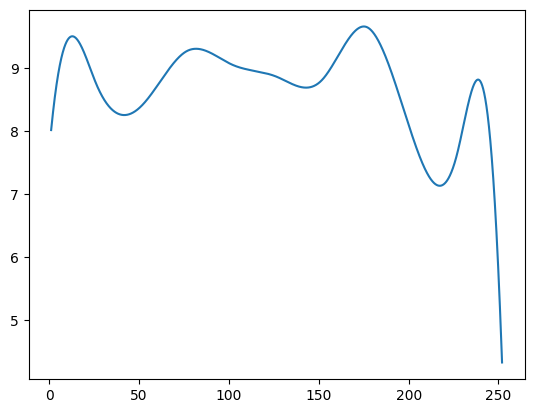

array([  1.        ,   1.03347113,   1.06694226, ..., 251.93305774,
       251.96652887, 252.        ])

In [126]:

print(recons_test.shape)
plt.plot(eval_points,torch.t(recons_test[0]).detach().cpu())
plt.show()
eval_points

In [ ]:
sp500_companies = [
    'AAPL', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK',
    'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'AOS', 'APA', 'APD',
    'APH', 'APTV', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BIIB',
    'BIO', 'BK', 'BKNG', 'BKR', 'BLK', 'BLL', 'BMY', 'BR', 'BRK.B', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CARR', 'CAT', 'CB',
    'CBOE', 'CBRE', 'CCI', 'CCL', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHRW', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA',
    'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CRM', 'CSCO', 'CSX', 'CTAS',
    'CTLT', 'CTSH', 'CTVA', 'CTXS', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA',
    'DISCK', 'DISH', 'DLR', 'DLTR', 'DOV', 'DRE', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'DXCM', 'EA', 'EBAY', 'ECL', 'ED', 'EFX',
    'EIX', 'EL', 'EMN', 'EMR', 'ENPH', 'EOG', 'EQIX', 'EQR', 'ES', 'ESS', 'ETN', 'ETR', 'EVRG', 'EW', 'EXC', 'EXPD', 'EXPE', 'EXR',
    'F', 'FANG', 'FAST', 'FB', 'FBHS', 'FCX', 'FDX', 'FE', 'FFIV', 'FIS', 'FISV', 'FITB', 'FLIR', 'FMC', 'FRT', 'FTNT', 'FTV', 'GD',
    'GE', 'GILD', 'GIS', 'GL', 'GLW', 'GM', 'GNRC', 'GOOG', 'GOOGL', 'GPC', 'GPN', 'GPS', 'GRMN', 'GS', 'GWW', 'HAL', 'HAS', 'HBAN',
    'HBI', 'HCA', 'HD', 'HES', 'HIG', 'HII', 'HLT', 'HOLX', 'HON', 'HPE', 'HPQ', 'HRL', 'HSIC', 'HST', 'HSY', 'HUM', 'HWM', 'IBM',
    'ICE', 'IDXX', 'IEX', 'IFF', 'ILMN', 'INCY', 'INFO', 'INTC', 'INTU', 'IP', 'IPG', 'IPGP', 'IQV', 'IR', 'IRM', 'ISRG', 'IT', 'ITW',
    'IVZ', 'J', 'JBHT', 'JCI', 'JKHY', 'JNJ', 'JNPR', 'JPM', 'K', 'KEY', 'KEYS', 'KHC', 'KIM', 'KLAC', 'KMB', 'KMI', 'KMX', 'KO',
    'KR', 'KSU', 'L', 'LB', 'LDOS', 'LEG', 'LEN', 'LH', 'LHX', 'LIN', 'LKQ', 'LLY', 'LMT', 'LNC', 'LNT', 'LOW', 'LRCX', 'LUMN',
    'LUV', 'LVS', 'LW', 'LYB', 'LYV', 'MA', 'MAA', 'MAR', 'MAS', 'MCD', 'MCHP', 'MCK', 'MCO', 'MDLZ', 'MDT', 'MET', 'MGM', 'MHK',
    'MKC', 'MKTX', 'MLM', 'MMC', 'MMM', 'MNST', 'MO', 'MOS', 'MPC', 'MPWR', 'MRK', 'MRO', 'MSCI', 'MSFT', 'MSI', 'MTB', 'MTD', 'MU',
    'MXIM', 'NCLH', 'NDAQ', 'NEE', 'NEM', 'NFLX', 'NKE', 'NLOK', 'NLSN', 'NOC', 'NOV', 'NRG', 'NSC', 'NTAP', 'NTRS', 'NUE', 'NVDA',
    'NVR', 'NWL', 'NWS', 'NWSA', 'NXPI', 'O', 'ODFL', 'OKE', 'OMC', 'ORCL', 'ORLY', 'OTIS', 'OXY', 'PAYC', 'PAYX', 'PBCT', 'PCAR',
    'PEAK', 'PEG', 'PENN', 'PEP', 'PFE', 'PFG', 'PG', 'PGR', 'PH', 'PHM', 'PKG', 'PKI', 'PLD', 'PM', 'PNC', 'PNR', 'PNW', 'PPG',
    'PPL', 'PRGO', 'PRU', 'PSA', 'PSX', 'PTC', 'PVH', 'PWR', 'PXD', 'PYPL', 'QCOM', 'QRVO', 'RCL', 'RE', 'REG', 'REGN', 'RF', 'RHI',
    'RJF', 'RL', 'RMD', 'ROK', 'ROL', 'ROP', 'ROST', 'RSG', 'RTX', 'SBAC', 'SBUX', 'SCHW', 'SEE', 'SHW', 'SIVB', 'SJM', 'SLB',
    'SLG', 'SNA', 'SNPS', 'SO', 'SPG', 'SPGI', 'SRE', 'STE', 'STT', 'STX', 'STZ', 'SWK', 'SWKS', 'SYF', 'SYK', 'SYY', 'T', 'TAK',
    'TAP', 'TDG', 'TDY', 'TEL', 'TER', 'TFC', 'TFX', 'TGT', 'TIF', 'TJX', 'TMO', 'TMUS', 'TPR', 'TRMB', 'TROW', 'TRV', 'TSCO',
    'TSN', 'TT', 'TTWO', 'TWTR', 'TXN', 'TXT', 'TYL', 'U', 'UA', 'UAA', 'UAL', 'UDR', 'UHS', 'ULTA', 'UNH', 'UNM', 'UNP', 'UPS',
    'URI', 'USB', 'V', 'VAR', 'VFC', 'VIAC', 'VLO', 'VMC', 'VNO', 'VRSK', 'VRSN', 'VRTX', 'VTR', 'VTRS', 'VZ', 'WAB', 'WAT', 'WBA',
    'WDC', 'WEC', 'WELL', 'WFC', 'WHR', 'WLTW', 'WM', 'WMB', 'WMT', 'WRB', 'WRK', 'WST', 'WU', 'WY', 'WYNN', 'XEL', 'XLNX', 'XOM',
    'XRAY', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZION', 'ZTS'
]

# Vérifier qu'il y a bien 500 entreprises dans la liste
len(sp500_companies)


In [ ]:
# # from_torch_to_Datagrid(y_train).plot()
# y_train.plot()
# y_train.to_basis(y_basis).plot()
# plt.show()